In [4]:
import pandas as pd
import scipy.stats
import numpy as np
import math
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

df = pd.read_excel("./Final_Dataset.xlsx")
df.head(5)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914,41,30,129,129,...,0,20170325,4,2,0,1,16,20,4105.797,0
1,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,4,30,male,9,20110916,39,30,149,149,...,0,20170329,0,1,1,2,100,12,24191.356,0
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,20110918,40,30,149,149,...,0,20170329,0,0,0,0,24,19,6251.930,0
3,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,5,27,male,9,20110927,39,30,149,149,...,0,20170316,7,3,1,1,46,48,11125.928,0
4,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,14,26,female,9,20111005,37,30,149,149,...,0,20170315,1,0,0,0,11,11,2835.853,0


In [5]:
# Handle missing values
# continuous_features = ['payment_plan_days', 'plan_list_price', 'actual_amount_paid']
continuous_features = ['bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
df[continuous_features] = df[continuous_features].fillna(df[continuous_features].median())

categorical_features = ['city', 'gender', 'registered_via', 'payment_method_id', 'is_auto_renew', 'is_cancel', 'is_churn']
df[categorical_features] = df[categorical_features].apply(lambda x: x.fillna(x.mode().iloc[0]))

# Remove outliers using the IQR method for continuous features
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Convert datetime features into more meaningful numeric features
df.loc[:, 'transaction_date'] = pd.to_datetime(df['transaction_date'], format='%Y%m%d')
df.loc[:, 'membership_expire_date'] = pd.to_datetime(df['membership_expire_date'], format='%Y%m%d')
df.loc[:, 'registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d')
df.loc[:, 'date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Calculate tenure (time between transaction_date and membership_expire_date)
df['tenure'] = (df['membership_expire_date'] - df['transaction_date']).dt.days

# Calculate days_since_last_transaction (assuming a reference date)
reference_date = pd.to_datetime('2023-04-08')
df['days_since_last_transaction'] = (reference_date - df['transaction_date']).dt.days

df.head(5)


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn,tenure,days_since_last_transaction
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,male,7,2011-09-14,41,30,129,129,...,4,2,0,1,16,20,4105.797,0,32,2203
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,2011-09-18,40,30,149,149,...,0,0,0,0,24,19,6251.930,0,30,2203
3,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,5,27,male,9,2011-09-27,39,30,149,149,...,7,3,1,1,46,48,11125.928,0,62,2230
4,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,14,26,female,9,2011-10-05,37,30,149,149,...,1,0,0,0,11,11,2835.853,0,30,2226
8,m0h0+lJIok7k6BzAoOnq+x+mB1tbi9shGF/egYLbed4=,4,22,female,7,2014-10-20,36,30,180,180,...,4,2,0,0,22,21,5735.900,0,30,2214


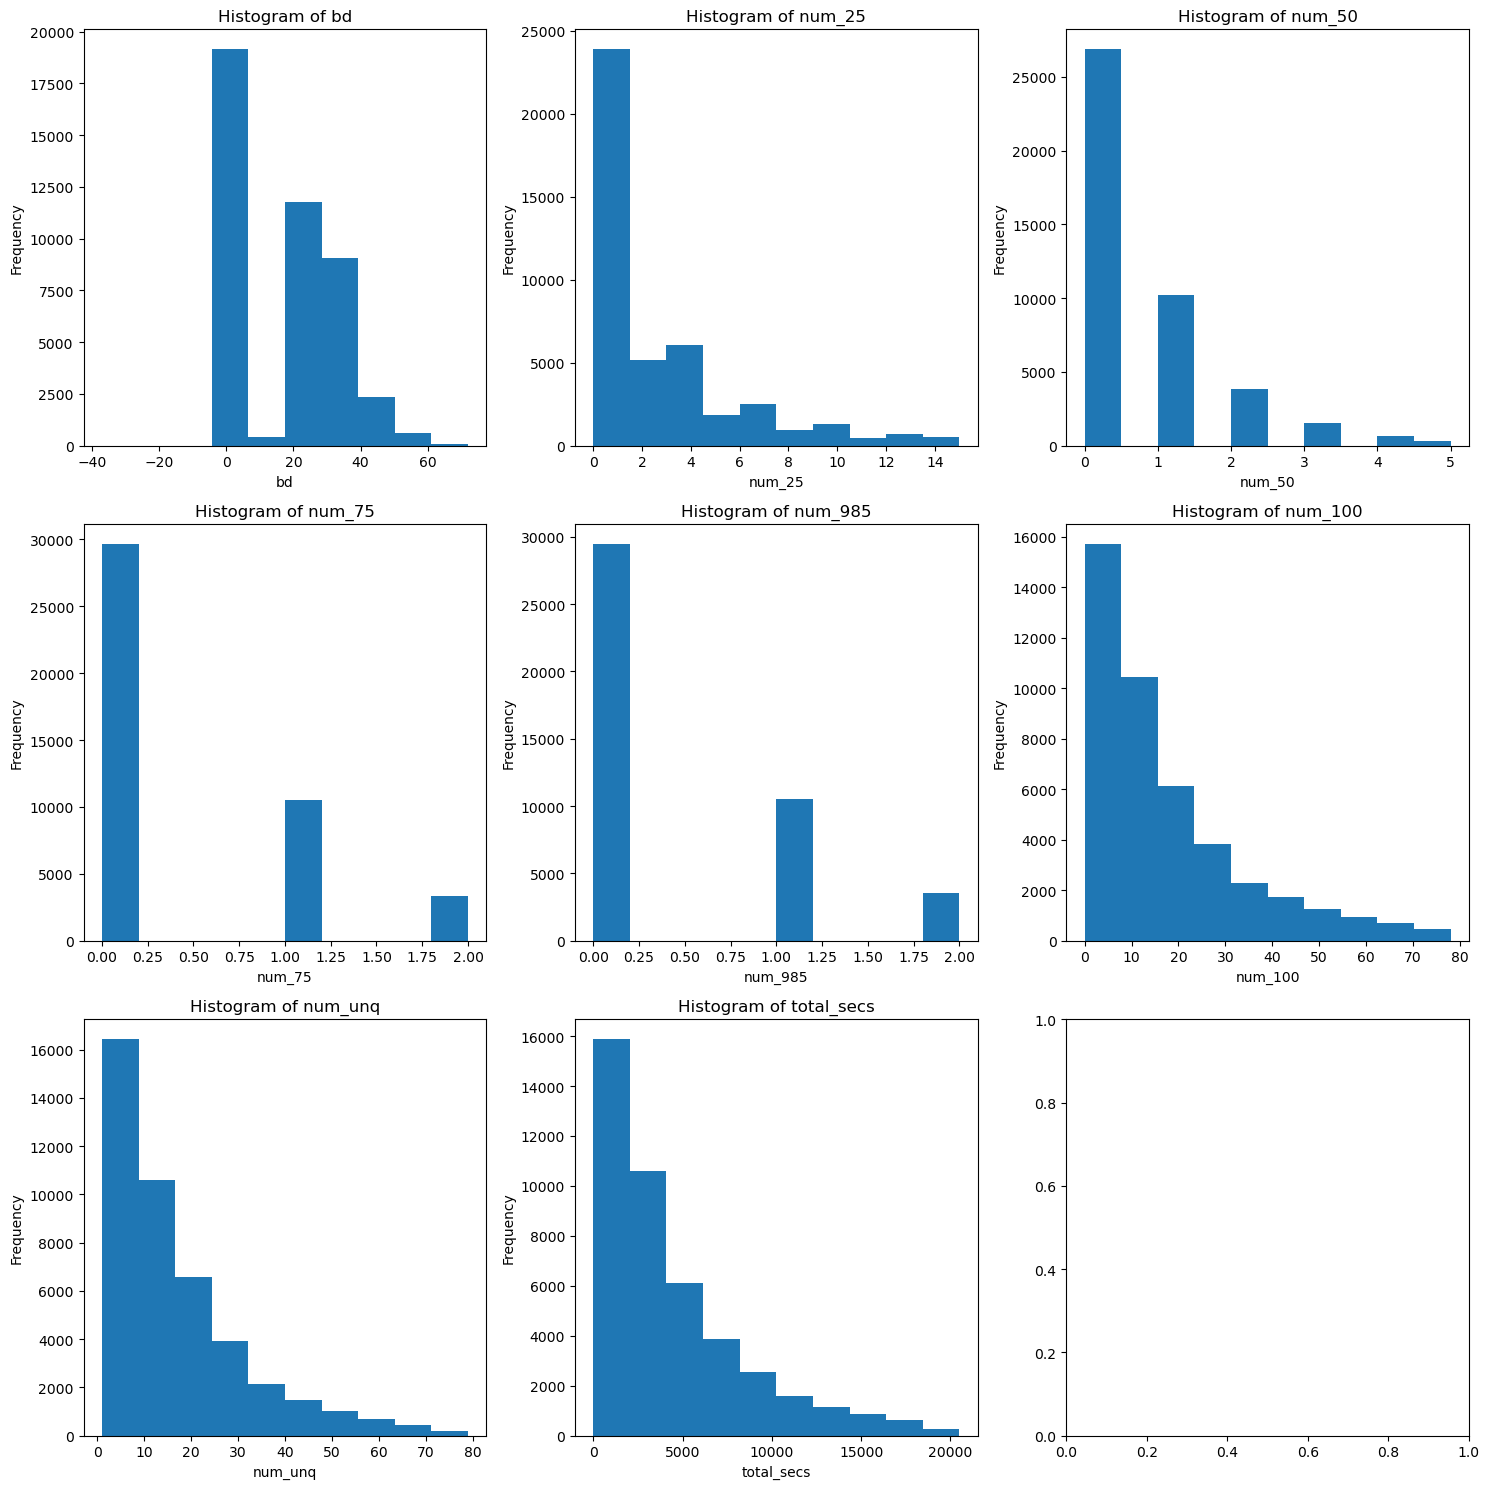

In [6]:
numeric_features = ['bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
num_plots = len(numeric_features)
num_rows = math.ceil(num_plots / 3)
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, feature in enumerate(numeric_features):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].hist(df[feature])
    axs[row, col].set_title(f'Histogram of {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [7]:
# numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = ['bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

# Calculate skewness for all numeric features
skewness = df[numeric_features].skew()

skewness

bd            0.259099
num_25        1.750507
num_50        1.931248
num_75        1.337652
num_985       1.317001
num_100       1.433104
num_unq       1.462247
total_secs    1.435670
dtype: float64

In [8]:
# Get features with positive skewness
pos_skew_features = skewness[skewness > 1].index.tolist()

# Get features with negative skewness
neg_skew_features = skewness[skewness < -1].index.tolist()

# Apply logarithmic transformation to positive skewness features
for feature in pos_skew_features:
    df[feature] = np.log1p(df[feature])
#     print("yes")

# Apply exponential transformation to negative skewness features
for feature in neg_skew_features:
    df[feature] = np.exp(df[feature])
#     print("no")


In [9]:
numeric_features = ['bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

# Calculate skewness for all numeric features
skewness = df[numeric_features].skew()

print(skewness)

bd            0.259099
num_25        0.450934
num_50        1.033094
num_75        1.021316
num_985       1.002875
num_100      -0.389038
num_unq      -0.244428
total_secs   -1.077060
dtype: float64


In [10]:
# Select only continuous features
continuous_features = ['bd', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'is_churn']

# Standardize continuous features
scaler = StandardScaler()
df.loc[:, continuous_features] = scaler.fit_transform(df.loc[:, continuous_features])

# Normalize continuous features
scaler = MinMaxScaler()
df.loc[:, continuous_features] = scaler.fit_transform(df.loc[:, continuous_features])

df.head(5)


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn,tenure,days_since_last_transaction
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0.339450,male,7,2011-09-14,1.000000,0.066667,0.072148,0.072148,...,0.580482,0.613147,0.00000,0.63093,0.648414,0.637423,0.835485,0.0,32,2203
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,0.917431,male,9,2011-09-18,0.967742,0.066667,0.083333,0.083333,...,0.000000,0.000000,0.00000,0.00000,0.736678,0.624196,0.878508,0.0,30,2203
3,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,5,0.587156,male,9,2011-09-27,0.935484,0.066667,0.083333,0.083333,...,0.750000,0.773706,0.63093,0.63093,0.881152,0.867112,0.937485,0.0,62,2230
4,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,14,0.577982,female,9,2011-10-05,0.870968,0.066667,0.083333,0.083333,...,0.250000,0.000000,0.00000,0.00000,0.568700,0.485719,0.797627,0.0,30,2226
8,m0h0+lJIok7k6BzAoOnq+x+mB1tbi9shGF/egYLbed4=,4,0.541284,female,7,2014-10-20,0.838710,0.066667,0.100671,0.100671,...,0.580482,0.613147,0.00000,0.00000,0.717595,0.650034,0.869693,0.0,30,2214


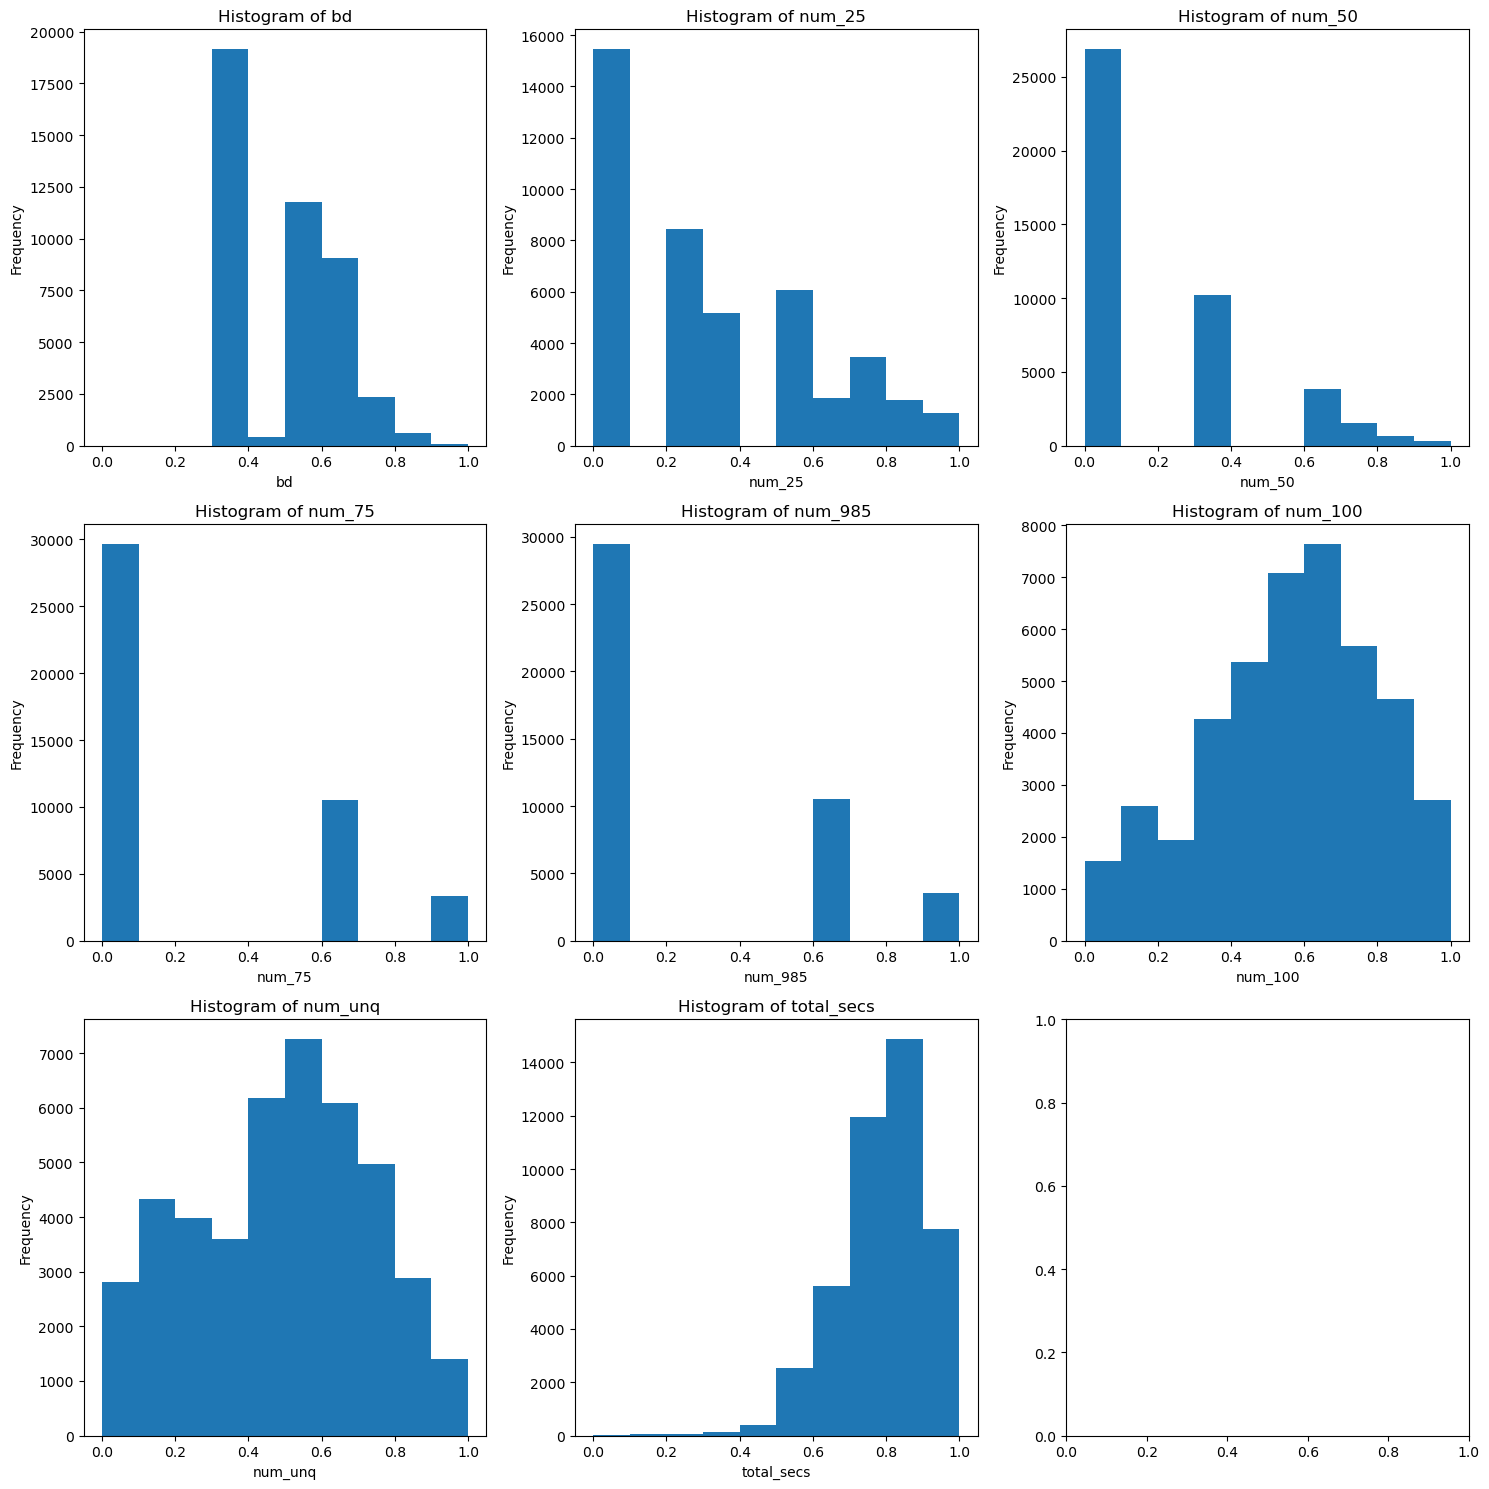

In [11]:
numeric_features = ['bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
num_plots = len(numeric_features)
num_rows = math.ceil(num_plots / 3)
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, feature in enumerate(numeric_features):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].hist(df[feature])
    axs[row, col].set_title(f'Histogram of {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [12]:
# Calculate user engagement metrics

df['avg_daily_songs'] = df['num_100'] / df['tenure']
df['avg_daily_listening_time'] = df['total_secs'] / df['tenure']
df['days_since_last_play'] = pd.to_datetime('2017-03-31') - df['date']
df['days_since_last_play'] = df['days_since_last_play'].dt.days

df = df.replace([np.inf, -np.inf], np.nan)

continuous_features = ['avg_daily_songs', 'avg_daily_listening_time', 'days_since_last_play']
df[continuous_features] = df[continuous_features].fillna(df[continuous_features].median())

# Identify churn-related customer service factors
churned_df = df[df['is_churn'] == 1]
churned_reg_methods = churned_df['registered_via'].value_counts(normalize=True)
churned_auto_renew = churned_df['is_auto_renew'].value_counts(normalize=True)

print('Churned users registration methods:')
print(churned_reg_methods)

print('Churned users auto-renewal status:')
print(churned_auto_renew)


Churned users registration methods:
9     0.467112
7     0.235726
3     0.206010
4     0.088815
13    0.002337
Name: registered_via, dtype: float64
Churned users auto-renewal status:
0    0.520868
1    0.479132
Name: is_auto_renew, dtype: float64


In [13]:
print(df.isnull().sum())

msno                           0
city                           0
bd                             0
gender                         0
registered_via                 0
registration_init_time         0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
date                           0
num_25                         0
num_50                         0
num_75                         0
num_985                        0
num_100                        0
num_unq                        0
total_secs                     0
is_churn                       0
tenure                         0
days_since_last_transaction    0
avg_daily_songs                0
avg_daily_listening_time       0
days_since_last_play           0
dtype: int64


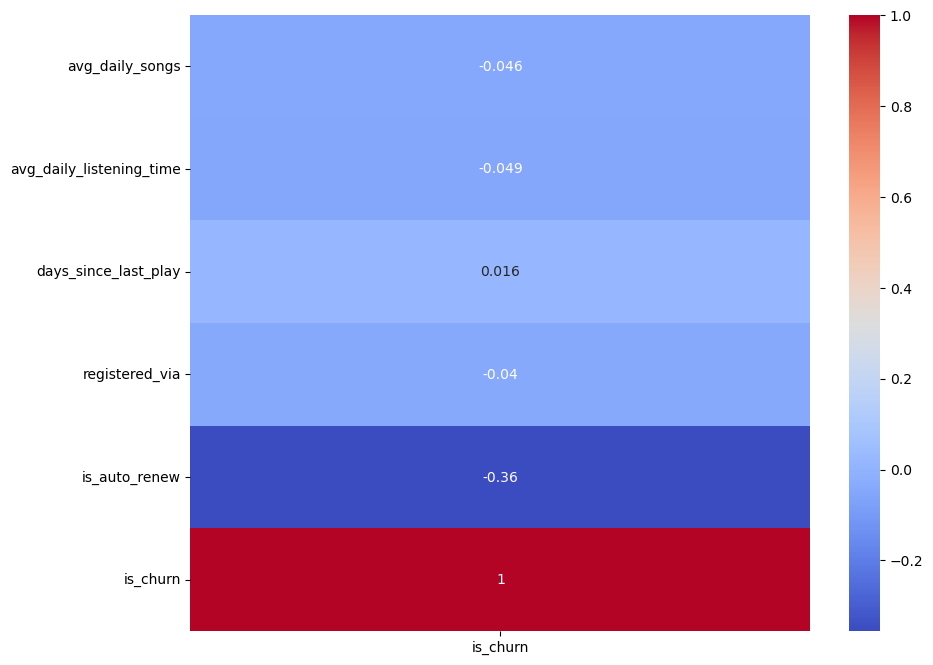

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# select the columns of interest
selected_cols = ['avg_daily_songs', 'avg_daily_listening_time', 'days_since_last_play', 'registered_via', 'is_auto_renew', 'is_churn']

# create a new dataframe with only the selected columns
df_selected = df[selected_cols]

# fill missing values with median
df_selected = df_selected.fillna(df_selected.median())

# encode categorical features as numerical values
# df_encoded = pd.get_dummies(df_selected, columns=['registered_via', 'is_auto_renew'])

# calculate correlation matrix
corr_matrix = df_selected.corr()

# plot the correlation heatmap for selected features and churn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['is_churn']], annot=True, cmap='coolwarm')
plt.show()


In [15]:
# Check class distribution
print(df["is_churn"].value_counts(normalize=True))

0.0    0.931123
1.0    0.068877
Name: is_churn, dtype: float64


In [16]:
# Assuming your preprocessed dataset is named `df` and the target variable is 'is_churn'
X = df.drop(['is_churn','msno'], axis=1)
y = df['is_churn']

# Extract year from datetime columns
datetime_columns = X.select_dtypes(include=['datetime64[ns]']).columns

for column in datetime_columns:
    X[column+'_year'] = X[column].dt.year
    X.drop(column, axis=1, inplace=True)

# Identify categorical columns (excluding the datetime columns processed earlier)
categorical_columns = X.select_dtypes(include=['object']).columns

# Convert the 'gender' column to binary
X['gender'] = X['gender'].replace({'male': 1, 'female': 0})

X.head(5)


,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,...,total_secs,tenure,days_since_last_transaction,avg_daily_songs,avg_daily_listening_time,days_since_last_play,registration_init_time_year,transaction_date_year,membership_expire_date_year,date_year
0,1,0.339450,1,7,1.000000,0.066667,0.072148,0.072148,1,0,...,0.835485,32,2203,0.020263,0.026109,6,2011,2017,2017,2017
2,13,0.917431,1,9,0.967742,0.066667,0.083333,0.083333,1,0,...,0.878508,30,2203,0.024556,0.029284,2,2011,2017,2017,2017
3,5,0.587156,1,9,0.935484,0.066667,0.083333,0.083333,1,0,...,0.937485,62,2230,0.014212,0.015121,15,2011,2017,2017,2017
4,14,0.577982,0,9,0.870968,0.066667,0.083333,0.083333,1,0,...,0.797627,30,2226,0.018957,0.026588,16,2011,2017,2017,2017
8,4,0.541284,0,7,0.838710,0.066667,0.100671,0.100671,1,0,...,0.869693,30,2214,0.023920,0.028990,1,2014,2017,2017,2017


In [17]:
# Define a list of features related to Customer Service and User Engagement
cust_service_engagement_features = ['registered_via', 'is_auto_renew', 'avg_daily_songs', 'avg_daily_listening_time', 'days_since_last_play']

# Create a new DataFrame with only the selected features and the target variable 'is_churn'
X_cust_service_engagement = X[cust_service_engagement_features]

# Split the data into train and test sets
X_train_cse, X_test_cse, y_train_cse, y_test_cse = train_test_split(X_cust_service_engagement, y, test_size=0.2, random_state=42, stratify=y)

# Apply RandomUnderSampler
rus_cse = RandomUnderSampler(random_state=42)
X_resampled_cse, y_resampled_cse = rus_cse.fit_resample(X_train_cse, y_train_cse)

# Train a decision tree classifier on the resampled data
classifier_cse = DecisionTreeClassifier(random_state=42)
classifier_cse.fit(X_resampled_cse, y_resampled_cse)

# Get the feature importances for Customer Service and User Engagement features
importances_cse = pd.Series(classifier_cse.feature_importances_, index=X_cust_service_engagement.columns)
importances_sorted_cse = importances_cse.sort_values(ascending=False)

# Print the feature importances
print("Feature importances for Customer Service and User Engagement:\n", importances_sorted_cse)


Feature importances for Customer Service and User Engagement:
 avg_daily_listening_time    0.643891
avg_daily_songs             0.172291
is_auto_renew               0.083322
days_since_last_play        0.081496
registered_via              0.019000
dtype: float64


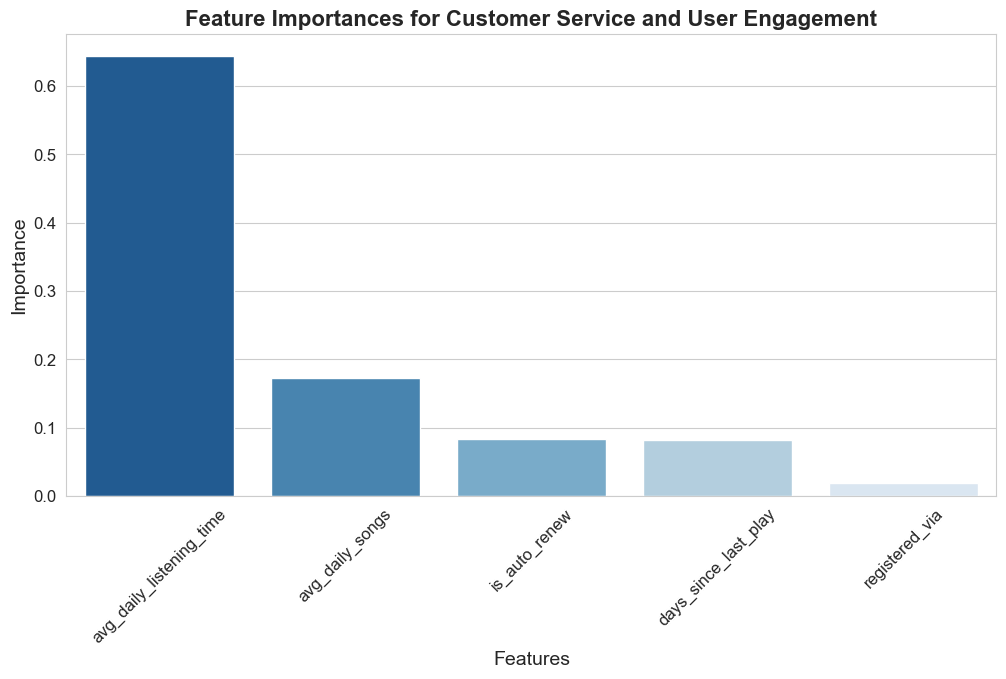

In [18]:
# Set seaborn style
sns.set_style("whitegrid")

# Create a bar plot of the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=importances_sorted_cse.index, y=importances_sorted_cse.values, palette="Blues_r")
plt.title('Feature Importances for Customer Service and User Engagement', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [19]:
y_pred = classifier_cse.predict(X_test_cse)

# Convert the y_pred array to a Python list
y_pred_list = y_pred.tolist()


In [20]:
# Calculate the evaluation metrics
accuracy = accuracy_score(y_test_cse, y_pred)
classification_report_str = classification_report(y_test_cse, y_pred)
confusion_mtx = confusion_matrix(y_test_cse, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification report:\n", classification_report_str)
print("Confusion matrix:\n", confusion_mtx)

Accuracy: 0.8313211452224906
Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      8098
         1.0       0.26      0.79      0.39       599

    accuracy                           0.83      8697
   macro avg       0.62      0.81      0.65      8697
weighted avg       0.93      0.83      0.87      8697

Confusion matrix:
 [[6756 1342]
 [ 125  474]]


Optimal k based on combined scores: 2


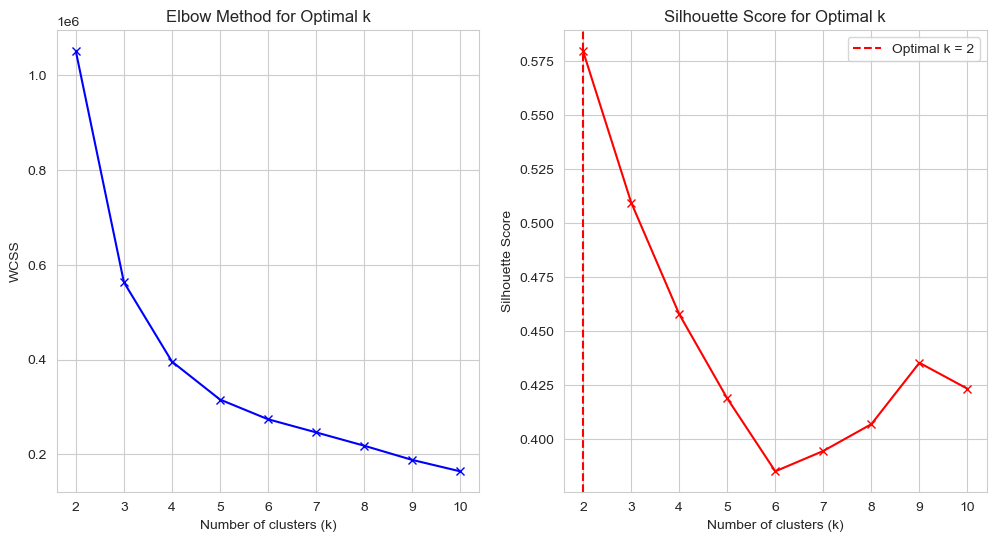

In [21]:
# Step 4: User Segmentation Based on Engagement

# Select engagement metrics for clustering
cust_service_engagement_features = ['registered_via', 'is_auto_renew', 'avg_daily_songs', 'avg_daily_listening_time', 'days_since_last_play']

X_engagement = df[cust_service_engagement_features]

# Calculate WCSS (Within Cluster Sum of Squares) for different cluster numbers
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_engagement)
    wcss.append(kmeans.inertia_)

# Calculate silhouette scores for different cluster numbers
sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_engagement)
    sil_scores.append(silhouette_score(X_engagement, labels))

# Function to normalize values between 0 and 1
def normalize(values):
    min_val = min(values)
    max_val = max(values)
    return [(v - min_val) / (max_val - min_val) for v in values]

# Normalize WCSS and Silhouette Scores
normalized_wcss = normalize(wcss)
normalized_sil_scores = normalize(sil_scores)

# Assign weights to each method (sum of weights should be 1)
weight_wcss = 0.5
weight_sil_score = 0.5

# Calculate the combined scores
combined_scores = [weight_wcss * w + weight_sil_score * s for w, s in zip(normalized_wcss, normalized_sil_scores)]

# Find the optimal k based on the combined scores
optimal_k_combined = combined_scores.index(max(combined_scores)) + 2
print("Optimal k based on combined scores:", optimal_k_combined)

# Plot WCSS (Elbow Method)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores, 'rx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.axvline(x=optimal_k_combined, color='r', linestyle='--', label=f'Optimal k = {optimal_k_combined}')
plt.legend()

plt.show()


In [22]:
# Apply K-means clustering with the optimal number of clusters (I have selected as 4 by seeing the two graphs)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X_engagement)
df.head(5)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,num_100,num_unq,total_secs,is_churn,tenure,days_since_last_transaction,avg_daily_songs,avg_daily_listening_time,days_since_last_play,cluster
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0.339450,male,7,2011-09-14,1.000000,0.066667,0.072148,0.072148,...,0.648414,0.637423,0.835485,0.0,32,2203,0.020263,0.026109,6,2
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,0.917431,male,9,2011-09-18,0.967742,0.066667,0.083333,0.083333,...,0.736678,0.624196,0.878508,0.0,30,2203,0.024556,0.029284,2,2
3,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,5,0.587156,male,9,2011-09-27,0.935484,0.066667,0.083333,0.083333,...,0.881152,0.867112,0.937485,0.0,62,2230,0.014212,0.015121,15,3
4,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,14,0.577982,female,9,2011-10-05,0.870968,0.066667,0.083333,0.083333,...,0.568700,0.485719,0.797627,0.0,30,2226,0.018957,0.026588,16,3
8,m0h0+lJIok7k6BzAoOnq+x+mB1tbi9shGF/egYLbed4=,4,0.541284,female,7,2014-10-20,0.838710,0.066667,0.100671,0.100671,...,0.717595,0.650034,0.869693,0.0,30,2214,0.023920,0.028990,1,2


   engagement_cluster  churn_rate  avg_songs_per_day  \
0                   0    0.067204           0.016387   
1                   1    0.072755           0.015939   
2                   2    0.061756           0.016153   
3                   3    0.073033           0.016550   

   avg_daily_listening_time  num_users  
0                  0.022958      11294  
1                  0.022712      11147  
2                  0.022802       9910  
3                  0.023163      11132  


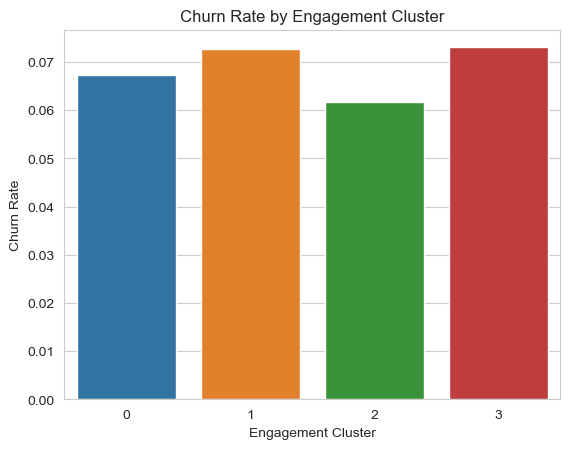

                    Feature  Importance
3  avg_daily_listening_time    0.508607
2           avg_daily_songs    0.281836
1             is_auto_renew    0.102764
4      days_since_last_play    0.080834
0            registered_via    0.025959


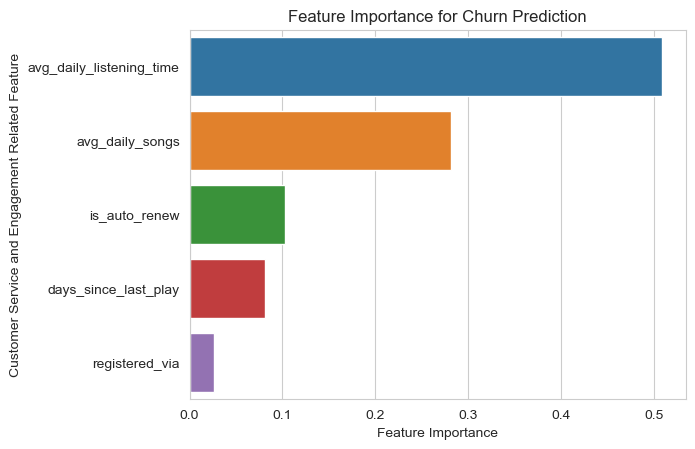

In [23]:
# Calculate churn rates and average engagement levels for each cluster
cluster_summary = df.groupby('cluster').agg({
    'is_churn': 'mean',
    'avg_daily_songs': 'mean',
    'avg_daily_listening_time': 'mean',
    'msno': 'count'
}).reset_index()

# Rename columns for better readability
cluster_summary.columns = [
    'engagement_cluster', 'churn_rate', 'avg_songs_per_day', 'avg_daily_listening_time', 'num_users'
]

# Display cluster_summary
print(cluster_summary)

# Plot churn rates by user segment
sns.barplot(x='engagement_cluster', y='churn_rate', data=cluster_summary)
plt.xlabel("Engagement Cluster")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Engagement Cluster")
plt.show()

# Select customer service-related features and target variable (churn)
customer_service_features = df[['registered_via', 'is_auto_renew', 'avg_daily_songs', 'avg_daily_listening_time', 'days_since_last_play']]
target = df['is_churn']

# Create a random forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier
clf.fit(customer_service_features, target)

# Get feature importances
importances = clf.feature_importances_

# Display feature importances
feature_importances = pd.DataFrame({
    'Feature': customer_service_features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Plot feature importances
sns.barplot(x='Importance', y='Feature', data=feature_importances, orient='h')
plt.xlabel("Feature Importance")
plt.ylabel("Customer Service and Engagement Related Feature")
plt.title("Feature Importance for Churn Prediction")
plt.show()


In [24]:
# Find the cluster with the lowest churn rate
lowest_churn_cluster = cluster_summary.loc[cluster_summary['churn_rate'].idxmin(), 'engagement_cluster']

print(f"The cluster with the lowest churn rate is cluster {lowest_churn_cluster}.")

The cluster with the lowest churn rate is cluster 2.


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# Train multiple models and store them in a dictionary
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=10000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "SVC": SVC(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Evaluate the models
for model_name, model in models.items():
    model.fit(X_train_cse, y_train_cse)
    y_pred = model.predict(X_test_cse)
    
    accuracy = accuracy_score(y_test_cse, y_pred)
    f1 = f1_score(y_test_cse, y_pred)
    precision = precision_score(y_test_cse, y_pred, zero_division=0)
    recall = recall_score(y_test_cse, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\n")


LogisticRegression Performance:
Accuracy: 0.9311
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


DecisionTree Performance:
Accuracy: 0.9492
F1 Score: 0.6267
Precision: 0.6342
Recall: 0.6194


KNeighbors Performance:
Accuracy: 0.9570
F1 Score: 0.5952
Precision: 0.8462
Recall: 0.4591


SVC Performance:
Accuracy: 0.9311
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


RandomForest Performance:
Accuracy: 0.9638
F1 Score: 0.6878
Precision: 0.8463
Recall: 0.5793


GradientBoosting Performance:
Accuracy: 0.9634
F1 Score: 0.6660
Precision: 0.8980
Recall: 0.5292




In [29]:
# Analyze feature importances for the Random Forest model
importances = models["RandomForest"].feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train_cse.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(feature_importances)

# # Plot feature importances
# sns.barplot(x='Importance', y='Feature', data=feature_importances, orient='h')
# plt.xlabel("Feature Importance")
# plt.ylabel("Feature")
# plt.title("Feature Importance for Churn Prediction with Engagement Strategies")
# plt.show()


Random Forest Feature Importances:
                    Feature  Importance
3  avg_daily_listening_time    0.506184
2           avg_daily_songs    0.285393
1             is_auto_renew    0.100859
4      days_since_last_play    0.082471
0            registered_via    0.025092


In [30]:
# Define an engagement strategy function
def engagement_strategy(user_segment):
    if user_segment == 0:
        return "Since this cluster has a higher average days_since_last_transaction, it is important to send reminders or offers to encourage users to make more transactions. Consider providing personalized recommendations based on the user's listening history to encourage more engagement. Since the cluster has a higher proportion of male users, consider tailoring promotional offers or content to appeal to this demographic."
    elif user_segment == 1:
        return "Similar to Cluster 0, it is important to send reminders or offers to encourage users to make more transactions. Consider implementing a loyalty or rewards program to incentivize users to stay engaged with the service. Since this cluster has a higher average days_since_last_play, consider providing more personalized recommendations to users based on their listening history to encourage more engagement."
    elif user_segment == 2:
        return "Since this cluster has a much lower average days_since_last_transaction, it may be beneficial to focus on retaining users by providing high-quality content and personalized recommendations. Consider implementing a referral program to encourage current users to invite friends and family to join the service. Since this cluster has a higher proportion of male users, consider tailoring promotional offers or content to appeal to this demographic."
    else:
        return "Since this cluster has a higher proportion of female users, consider tailoring promotional offers or content to appeal to this demographic. Consider implementing social features, such as user-generated playlists or a community forum, to encourage more engagement and interaction among users. Since this cluster has a higher average days_since_last_play, consider providing more personalized recommendations to users based on their listening history to encourage more engagement."
        
# Apply the engagement strategy function to the user segments in your dataset
df['engagement_strategy'] = df['cluster'].apply(engagement_strategy)

# Display a sample of the dataset with engagement strategies
print(df.sample(10)[['cluster', 'engagement_strategy']])


       cluster                                engagement_strategy
16713        3  Since this cluster has a higher proportion of ...
35883        0  Since this cluster has a higher average days_s...
4996         1  Similar to Cluster 0, it is important to send ...
43395        1  Similar to Cluster 0, it is important to send ...
26188        2  Since this cluster has a much lower average da...
46455        3  Since this cluster has a higher proportion of ...
56765        3  Since this cluster has a higher proportion of ...
3937         2  Since this cluster has a much lower average da...
18892        2  Since this cluster has a much lower average da...
44820        0  Since this cluster has a higher average days_s...


In [31]:
df.head(10)

,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,num_unq,total_secs,is_churn,tenure,days_since_last_transaction,avg_daily_songs,avg_daily_listening_time,days_since_last_play,cluster,engagement_strategy
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0.339450,male,7,2011-09-14,1.000000,0.066667,0.072148,0.072148,...,0.637423,0.835485,0.0,32,2203,0.020263,0.026109,6,2,Since this cluster has a much lower average da...
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,0.917431,male,9,2011-09-18,0.967742,0.066667,0.083333,0.083333,...,0.624196,0.878508,0.0,30,2203,0.024556,0.029284,2,2,Since this cluster has a much lower average da...
3,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,5,0.587156,male,9,2011-09-27,0.935484,0.066667,0.083333,0.083333,...,0.867112,0.937485,0.0,62,2230,0.014212,0.015121,15,3,Since this cluster has a higher proportion of ...
4,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,14,0.577982,female,9,2011-10-05,0.870968,0.066667,0.083333,0.083333,...,0.485719,0.797627,0.0,30,2226,0.018957,0.026588,16,3,Since this cluster has a higher proportion of ...
8,m0h0+lJIok7k6BzAoOnq+x+mB1tbi9shGF/egYLbed4=,4,0.541284,female,7,2014-10-20,0.838710,0.066667,0.100671,0.100671,...,0.650034,0.869693,0.0,30,2214,0.023920,0.028990,1,2,Since this cluster has a much lower average da...
9,7oCpSPj4+SdVJLfDRc+tN5HLp2R1DRozaWsTpbLTz5g=,15,0.532110,female,3,2014-10-20,0.967742,0.066667,0.083333,0.083333,...,0.743001,0.862287,1.0,64,2206,0.010887,0.013473,27,1,"Similar to Cluster 0, it is important to send ..."
10,vWYxNeXA8NwsiQQr7Beq5XQgCcj0y9N0YxEN2A2iqxI=,1,0.339450,male,9,2014-10-21,0.903226,0.066667,0.083333,0.083333,...,0.248393,0.752677,0.0,30,2200,0.016762,0.025089,27,1,"Similar to Cluster 0, it is important to send ..."
12,fkLgfIOX0bWM9/BQQChOCDzoos23szsckxPvxrBbtmY=,4,0.522936,female,9,2014-10-29,0.903226,0.066667,0.083333,0.083333,...,0.248393,0.775217,0.0,30,2229,0.016762,0.025841,27,1,"Similar to Cluster 0, it is important to send ..."
15,mlsuyquVwPXmJhd178ipGqdXJ6W7RSuDhd0fN+Pgn98=,13,0.522936,female,3,2014-11-01,0.903226,0.066667,0.083333,0.083333,...,0.248393,0.675001,0.0,30,2217,0.010576,0.022500,25,1,"Similar to Cluster 0, it is important to send ..."
17,0uAjNEzX6IY+lZ+PYv9W31mZjHxUWkbFz9LL8m9G46k=,15,0.550459,female,7,2014-11-03,1.000000,0.066667,0.072148,0.072148,...,0.867112,0.971418,0.0,31,2203,0.030931,0.031336,19,3,Since this cluster has a higher proportion of ...
